In [1]:
%load_ext autoreload
%autoreload 2

import sys, os
sys.path.append(os.path.dirname(os.path.dirname(os.getcwd())))
os.environ['PYTHONPATH'] = ':'.join(sys.path)

In [2]:
import numpy as np
import awkward as ak
import uproot
import matplotlib.pyplot as plt
from copy import deepcopy
from tqdm.notebook import tqdm

import hgpflow_v2.performance # don't know why this is needed, but it is
from hgpflow_v2.performance.performance import PerformanceCLIC

In [ ]:
truth_path = 'path to truth.root'

pred_path_mlpf_control1 = 'path to MLPF prediction seed 0.root'
pred_path_mlpf_control2 = 'path to MLPF prediction seed 1.root'
pred_path_mlpf_0p2subl  = 'path to MLPF prediction perturbed.root'

pred_path_control1 = 'path to HGPflow prediction seed 0.root'
pred_path_control2 = 'path to HGPflow prediction seed 1.root'
pred_path_0p2subl = 'path to HGPflow prediction perturbed.root'

perf_obj_control1 = PerformanceCLIC(
    truth_path, pred_path_control1, ind_threshold=0.65, pred_path_mlpf=pred_path_mlpf_control1, num_ev_in_one_file=5000,
    topo=True, truth_event_number_offset=55000, hgpf_target_path=hgpflow_target_path)

perf_obj_control2 = PerformanceCLIC(
    truth_path, pred_path_control2, ind_threshold=0.65, pred_path_mlpf=pred_path_mlpf_control2, num_ev_in_one_file=5000,
    topo=True, truth_event_number_offset=55000, hgpf_target_path=hgpflow_target_path)

perf_obj_0p2subl = PerformanceCLIC(
    truth_path, pred_path_0p2subl, ind_threshold=0.65, pred_path_mlpf=pred_path_mlpf_0p2subl, num_ev_in_one_file=5000,
    topo=True, truth_event_number_offset=55000, hgpf_target_path=hgpflow_target_path)

### Overwrite

- `hgpflow_pt` for neutral particles is better than `proxy_pt`
- But the rest are just worse
- So, I will just overwrite the `hgpflow_xxx` with `proxy_xxx` for the rest

In [4]:
for perf_obj in [perf_obj_control1, perf_obj_control2, perf_obj_0p2subl]:
    perf_obj.hgpflow_dict['hgpflow_eta'] = perf_obj.hgpflow_dict['proxy_eta']
    perf_obj.hgpflow_dict['hgpflow_phi'] = perf_obj.hgpflow_dict['proxy_phi']
    perf_obj.hgpflow_dict['hgpflow_pt'] = perf_obj.hgpflow_dict['proxy_pt']

    for i in range(len(perf_obj.hgpflow_dict['hgpflow_pt'])):
        ch_mask = perf_obj.hgpflow_dict['hgpflow_class'][i] <= 2
        perf_obj.hgpflow_dict['hgpflow_pt'][i][ch_mask] = perf_obj.hgpflow_dict['proxy_pt'][i][ch_mask]

In [ ]:
perf_obj_control1.compute_jets(n_procs=30)
perf_obj_control2.compute_jets(n_procs=30)
perf_obj_0p2subl.compute_jets(n_procs=30)

perf_obj_control1.match_jets()
perf_obj_control2.match_jets()
perf_obj_0p2subl.match_jets()

### Cluster Jet idx file

In [6]:
cluster_jet_idx_filepath = 'path to cluster_jet_idx.root'
cl_tree = uproot.open(cluster_jet_idx_filepath)['cluster_data']

cl_jet_e = cl_tree['jet_energy'].array(library='np')
cl_jet_eta = cl_tree['jet_eta'].array(library='np')
cl_jet_phi = cl_tree['jet_phi'].array(library='np')
cl_jet_idx = cl_tree['jet_idx'].array(library='np')

ref_leading_jet_e = []; ref_leading_jet_eta = []; ref_leading_jet_phi = []
ref_subleading_jet_e = []; ref_subleading_jet_eta = []; ref_subleading_jet_phi = []

for ev_i, jet_idx_ev in enumerate(cl_jet_idx):

    # leading jet
    lead_mask = jet_idx_ev == 0
    if lead_mask.sum() == 0:
        ref_leading_jet_e.append(np.nan)
        ref_leading_jet_eta.append(np.nan)
        ref_leading_jet_phi.append(np.nan)
    else:
        ref_leading_jet_e.append(np.unique(cl_jet_e[ev_i][lead_mask])[0])
        ref_leading_jet_eta.append(np.unique(cl_jet_eta[ev_i][lead_mask])[0])
        ref_leading_jet_phi.append(np.unique(cl_jet_phi[ev_i][lead_mask])[0])

    # subleading jet
    sublead_mask = jet_idx_ev == 1
    if sublead_mask.sum() == 0:
        ref_subleading_jet_e.append(np.nan)
        ref_subleading_jet_eta.append(np.nan)
        ref_subleading_jet_phi.append(np.nan)
    else:
        ref_subleading_jet_e.append(np.unique(cl_jet_e[ev_i][sublead_mask])[0])
        ref_subleading_jet_eta.append(np.unique(cl_jet_eta[ev_i][sublead_mask])[0])
        ref_subleading_jet_phi.append(np.unique(cl_jet_phi[ev_i][sublead_mask])[0])

ref_leading_jet_e = np.array(ref_leading_jet_e); ref_leading_jet_eta = np.array(ref_leading_jet_eta); ref_leading_jet_phi = np.array(ref_leading_jet_phi)
ref_subleading_jet_e = np.array(ref_subleading_jet_e); ref_subleading_jet_eta = np.array(ref_subleading_jet_eta); ref_subleading_jet_phi = np.array(ref_subleading_jet_phi)

In [7]:
def delta_R(eta1, phi1, eta2, phi2):
    deta = eta1 - eta2
    dphi = phi1 - phi2
    dphi = (dphi + np.pi) % (2 * np.pi) - np.pi
    return np.sqrt(deta**2 + dphi**2)

In [8]:
ref_lead_sublead_dr = delta_R(ref_leading_jet_eta, ref_leading_jet_phi, ref_subleading_jet_eta, ref_subleading_jet_phi)

Text(0.5, 0, '$\\Delta R \\left( \\text{lead jet, sub lead jet}\\right)$')

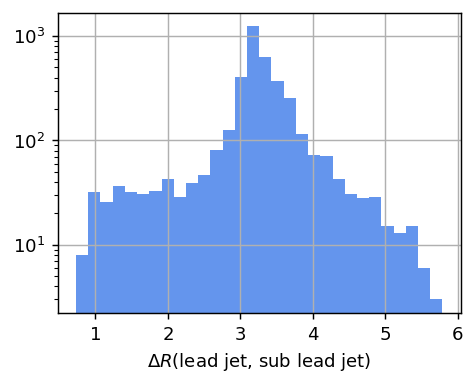

In [9]:
fig = plt.figure(figsize=(4, 3), dpi=130)
ax = fig.add_subplot(111)
ax.hist(ref_lead_sublead_dr, bins=30, color='cornflowerblue')
ax.set_yscale('log')
ax.grid()
ax.set_xlabel('$\Delta R \\left( \\text{lead jet, sub lead jet}\\right)$')

### Find jets matched to the leading jet from the cluster jet idx file

In [10]:
OFFSET = 55_000
DR_MATCH_TH = 0.1 # 100
DR_L_SUBL_TH = 1.5
SUBL_ETA_TH = 1.
L_ETA_TH = 1.5 # 1.5

In [11]:
matched_jet_dict_hgpf = {'ctrl1': [], 'ctrl2': [], '0p2subl': []}
matched_jet_dict_mlpf = {'ctrl1': [], 'ctrl2': [], '0p2subl': []}

zip_obj = zip(
    ['ctrl1', 'ctrl2', '0p2subl'], 
    [perf_obj_control1, perf_obj_control2, perf_obj_0p2subl])

for name, perf_obj in zip_obj:

    # hgpf
    for ev_i in range(len(cl_jet_e)):

        if (ref_lead_sublead_dr[ev_i] < DR_L_SUBL_TH) or (abs(ref_subleading_jet_eta[ev_i]) > SUBL_ETA_TH) or \
                (abs(ref_leading_jet_eta[ev_i]) > L_ETA_TH):
            matched_jet_dict_hgpf[name].append([np.nan, np.nan, np.nan])
            continue

        where_logic = np.where(perf_obj.truth_dict['event_number'] == ev_i + OFFSET)[0]
        if len(where_logic) == 0:
            matched_jet_dict_hgpf[name].append([np.nan, np.nan, np.nan])
            continue

        idx = where_logic[0]
        jets_ev = perf_obj.hgpflow_dict['jets'][idx]
    
        if len(jets_ev) > 0:
            dRs = delta_R(ref_leading_jet_eta[ev_i], ref_leading_jet_phi[ev_i], 
                np.array([j.eta for j in jets_ev]), np.array([j.phi for j in jets_ev]))

            dr_argmin = np.argmin(dRs)
            if dRs[dr_argmin] < DR_MATCH_TH:
                matched_jet_dict_hgpf[name].append(
                    [jets_ev[dr_argmin].e, jets_ev[dr_argmin].eta, jets_ev[dr_argmin].phi])
                continue

        matched_jet_dict_hgpf[name].append([np.nan, np.nan, np.nan])


    # mlpf
    for ev_i in range(len(cl_jet_e)):

        if (ref_lead_sublead_dr[ev_i] < DR_L_SUBL_TH) or (abs(ref_subleading_jet_eta[ev_i]) > SUBL_ETA_TH) or \
                (abs(ref_leading_jet_eta[ev_i]) > L_ETA_TH):
            matched_jet_dict_mlpf[name].append([np.nan, np.nan, np.nan])
            continue

        where_logic = np.where(perf_obj.truth_dict['event_number'] == ev_i + OFFSET)[0]
        if len(where_logic) == 0:
            matched_jet_dict_mlpf[name].append([np.nan, np.nan, np.nan])
            continue

        idx = where_logic[0]
        jets_ev = perf_obj.mlpf_dict['jets'][idx]
    
        if len(jets_ev) > 0:
            dRs = delta_R(ref_leading_jet_eta[ev_i], ref_leading_jet_phi[ev_i], 
                np.array([j.eta for j in jets_ev]), np.array([j.phi for j in jets_ev]))

            dr_argmin = np.argmin(dRs)
            if dRs[dr_argmin] < DR_MATCH_TH:
                matched_jet_dict_mlpf[name].append(
                    [jets_ev[dr_argmin].e, jets_ev[dr_argmin].eta, jets_ev[dr_argmin].phi])
                continue

        matched_jet_dict_mlpf[name].append([np.nan, np.nan, np.nan])


for k, v in matched_jet_dict_hgpf.items():
    matched_jet_dict_hgpf[k] = np.array(v)
for k, v in matched_jet_dict_mlpf.items():
    matched_jet_dict_mlpf[k] = np.array(v)

In [12]:
FIG_W = 12
FIG_H_1ROW = 4.5
FIG_DPI = 300


(np.float64(0.6928256596835076), np.float64(22227.814147407502))

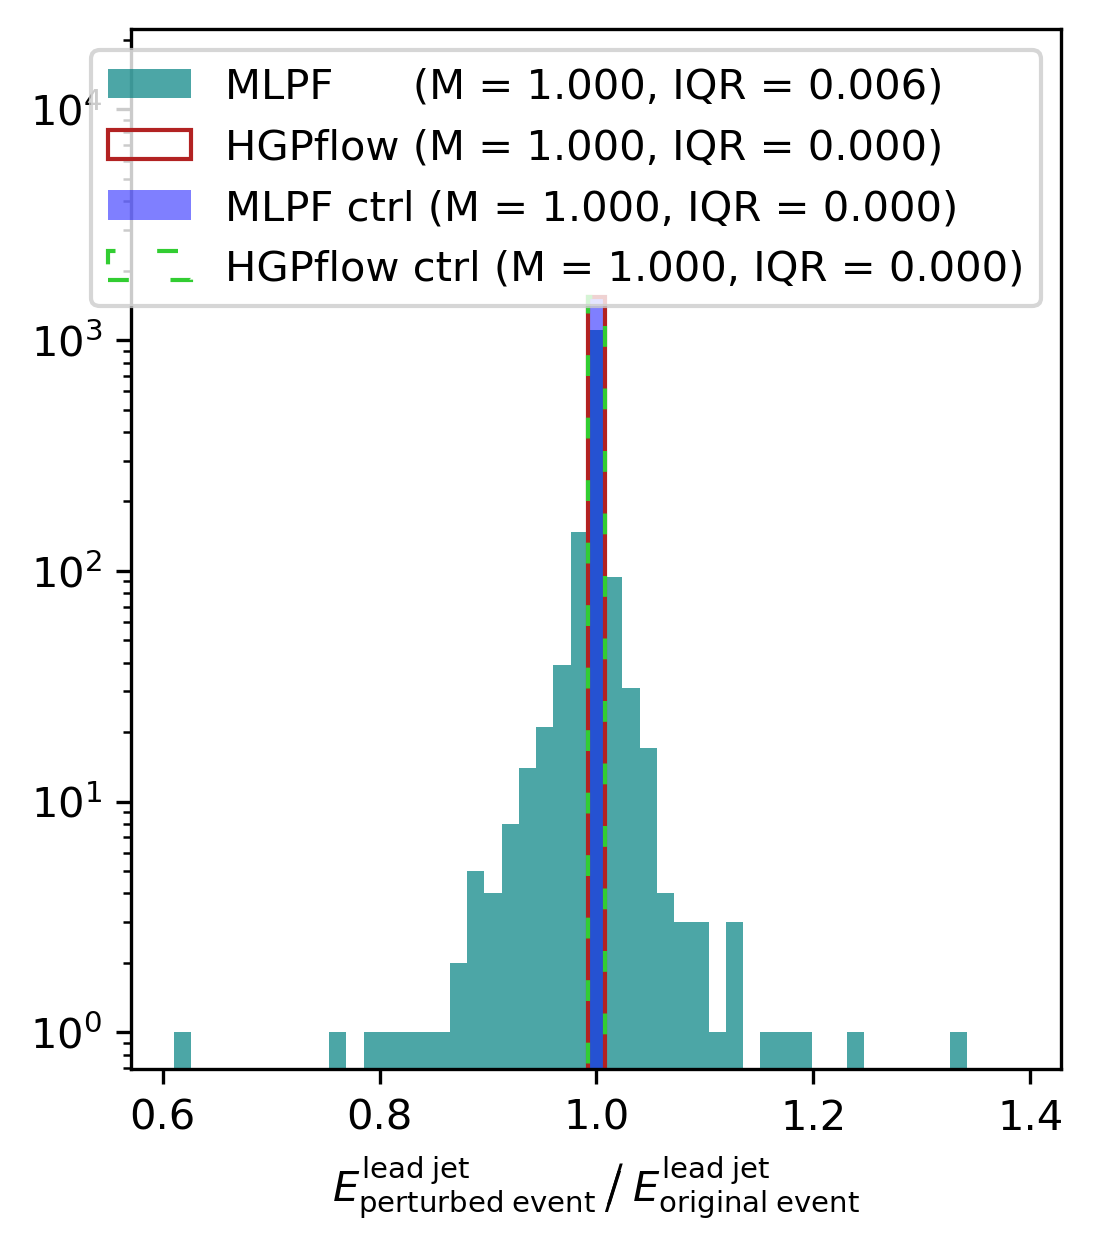

In [22]:
fig = plt.figure(figsize=(FIG_W/3, FIG_H_1ROW), dpi=FIG_DPI)
gs = fig.add_gridspec(1, 1, wspace=0.3, hspace=0.5)

# leading
ax1 = fig.add_subplot(gs[0])
r_mlpf_ptbd = matched_jet_dict_mlpf['0p2subl'][:,0] / matched_jet_dict_mlpf['ctrl1'][:,0]
r_hgpf_ptbd = matched_jet_dict_hgpf['0p2subl'][:,0] / matched_jet_dict_hgpf['ctrl1'][:,0]
r_mlpf_ctrl = matched_jet_dict_mlpf['ctrl2'][:,0] / matched_jet_dict_mlpf['ctrl1'][:,0]
r_hgpf_ctrl = matched_jet_dict_hgpf['ctrl2'][:,0] / matched_jet_dict_hgpf['ctrl1'][:,0]

extremum = max(np.nanmax(abs((r_mlpf_ptbd - 1))), np.nanmax(abs((r_hgpf_ptbd - 1))))
bins = np.linspace(1-extremum, 1+extremum, 50)

text = f'M = {np.nanmedian(r_mlpf_ptbd):.3f}, IQR = {np.nanpercentile(r_mlpf_ptbd, 75) - np.nanpercentile(r_mlpf_ptbd, 25):.3f}'
ax1.hist(r_mlpf_ptbd, bins=bins, histtype='stepfilled', color='teal', label=f'MLPF      ({text})', alpha=0.7)

text = f'M = {np.nanmedian(r_hgpf_ptbd):.3f}, IQR = {np.nanpercentile(r_hgpf_ptbd, 75) - np.nanpercentile(r_hgpf_ptbd, 25):.3f}'
ax1.hist(r_hgpf_ptbd, bins=bins, histtype='step', color='firebrick', label=f'HGPflow ({text})')

text = f'M = {np.nanmedian(r_mlpf_ctrl):.3f}, IQR = {np.nanpercentile(r_mlpf_ctrl, 75) - np.nanpercentile(r_mlpf_ctrl, 25):.3f}'
ax1.hist(r_mlpf_ctrl, bins=bins, histtype='stepfilled', color='blue', label=f'MLPF ctrl ({text})', alpha=0.5)

text = f'M = {np.nanmedian(r_hgpf_ctrl):.3f}, IQR = {np.nanpercentile(r_hgpf_ctrl, 75) - np.nanpercentile(r_hgpf_ctrl, 25):.3f}'
ax1.hist(r_hgpf_ctrl, bins=bins, histtype='step', color='limegreen', label=f'HGPflow ctrl ({text})', ls=(0, (5, 10)))

ax1.set_xlabel(r'$E^{\mathrm{lead} \; \mathrm{jet}}_{\mathrm{perturbed} \; \mathrm{event}} \; / \; E^{\mathrm{lead} \; \mathrm{jet}}_{\mathrm{original} \; \mathrm{event}}$')

ax1.text(
    0.5182, -0.089,  # Position relative to the axis (centered below the x-axis)
    "/",  # The text you want to make larger
    fontsize=14,  # Larger font size
    ha='center',  # Horizontal alignment
    va='top',  # Vertical alignment
    weight=0.8,
    transform=ax1.transAxes  # Use axis coordinates for positioning
)

ax1.legend()
# ax1.grid(True)
ax1.set_yscale('log')

ymin = ax1.get_ylim()[0]; ymax = ax1.get_ylim()[1]
ax1.set_ylim(ymin, 10 * ymax)